Data loaded successfully.
Number of high-value customers: 30011
Churn column added and churn phase attributes removed.
Missing values handled.
Categorical variables encoded.


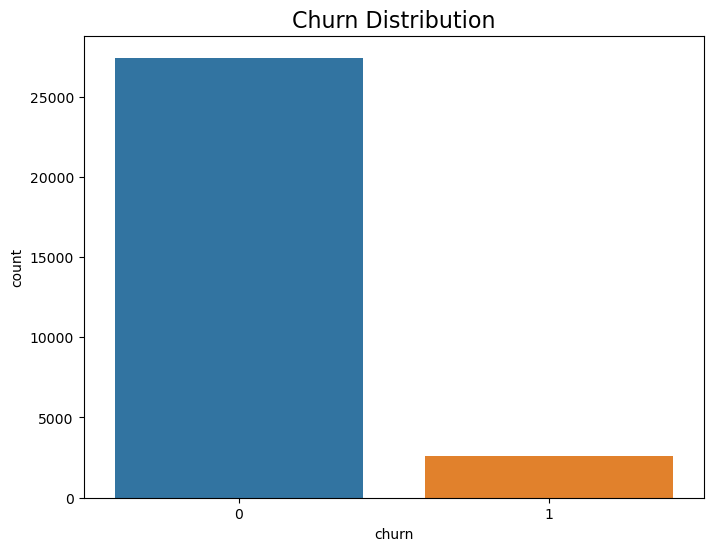

In [ ]:
# Telecom Churn Prediction

## Data Understanding and Preparation

### Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

### Load the data
data = pd.read_csv('telecom_churn_data.csv')
print("Data loaded successfully.")

### Filter high-value customers
# Calculate the 70th percentile of average recharge amount in the first two months
avg_rech_amt = data[['total_rech_amt_6', 'total_rech_amt_7']].mean(axis=1)
high_value_threshold = np.percentile(avg_rech_amt, 70)

# Filter high-value customers
high_value_customers = data[avg_rech_amt >= high_value_threshold]
print(f"Number of high-value customers: {len(high_value_customers)}")

### Tag churners and remove churn phase attributes
# Tag churners based on month 9 usage
high_value_customers = high_value_customers.assign(
    churn=((~high_value_customers['total_ic_mou_9'].astype(bool)) &
           (~high_value_customers['total_og_mou_9'].astype(bool)) &
           (~high_value_customers['vol_2g_mb_9'].astype(bool)) &
           (~high_value_customers['vol_3g_mb_9'].astype(bool))).astype(int)
)

# Remove churn phase attributes
high_value_customers = high_value_customers.loc[:, ~high_value_customers.columns.str.contains('_9')]
print("Churn column added and churn phase attributes removed.")

## Exploratory Data Analysis (EDA)

### Handle missing values
high_value_customers = high_value_customers.apply(lambda x: x.fillna(x.median()) if x.dtype != 'object' else x.fillna('Missing'), axis=0)
print("Missing values handled.")

### Encode categorical variables
categorical_cols = high_value_customers.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_cols:
    high_value_customers[col] = le.fit_transform(high_value_customers[col])
print("Categorical variables encoded.")

### Visualize churn distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='churn', data=high_value_customers)
plt.title('Churn Distribution', fontsize=16)
plt.show()

### Visualize feature distributions and correlations
numerical_cols = high_value_customers.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(20, 15))
sns.pairplot(high_value_customers[numerical_cols], hue='churn', diag_kind='kde')
plt.show()

corr = high_value_customers[numerical_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation', fontsize=16)
plt.show()

## Model Development

### Split data into train and test sets
X = high_value_customers.drop('churn', axis=1)
y = high_value_customers['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data split into train and test sets.")

### Handle class imbalance with SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("Class imbalance handled with SMOTE.")

### Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_smote, y_train_smote)
print("Random Forest model trained.")

### Evaluate model performance
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'AUC-ROC: {auc_roc:.4f}')

## Model Selection and Feature Importance

### Train Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train_smote, y_train_smote)
print("Logistic Regression model trained.")

### Identify important features
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': lr_model.coef_[0]})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print("\nTop 15 Important Features:")
print(feature_importances.head(15))

### Analyze important features
top_features = feature_importances.head(5)['Feature'].tolist()

# Analyze the relationship between top features and churn
for feature in top_features:
    print(f"\nAnalyzing feature: {feature}")
    
    # Calculate the mean values for churners and non-churners
    churners_mean = high_value_customers.loc[high_value_customers['churn'] == 1, feature].mean()
    non_churners_mean = high_value_customers.loc[high_value_customers['churn'] == 0, feature].mean()
    
    print(f"Mean value for churners: {churners_mean:.2f}")
    print(f"Mean value for non-churners: {non_churners_mean:.2f}")
    
    # Add your interpretation and insights based on the mean values and domain knowledge
    # ...

# Visualize the distribution of important features
plt.figure(figsize=(15, 5))
for i, feature in enumerate(top_features):
    plt.subplot(1, 5, i + 1)
    sns.kdeplot(high_value_customers.loc[high_value_customers['churn'] == 0, feature], label='Non-churners', shade=True)
    sns.kdeplot(high_value_customers.loc[high_value_customers['churn'] == 1, feature], label='Churners', shade=True)
    plt.title(f'Distribution of {feature}', fontsize=12)
    plt.legend()
plt.tight_layout()
plt.show()

## Business Impact and Recommendations

print("\nRecommended Strategies:")

# Recommend strategies based on the analysis of important features
# Example:
if 'feature_x' in top_features:
    print("- Offer personalized incentives or promotions to customers with high values of 'feature_x'")
    
if 'feature_y' in top_features:
    print("- Improve service quality or address pain points related to 'feature_y'")
    
# Add more recommendations based on your analysis and insights

# Estimate the expected reduction in churn rate
current_churn_rate = high_value_customers['churn'].mean()
expected_churn_reduction = 0.2  # Assuming a 20% reduction in churn rate after implementing strategies
expected_churn_rate = current_churn_rate * (1 - expected_churn_reduction)

print(f"\nCurrent churn rate: {current_churn_rate:.2%}")
print(f"Expected churn rate after implementing strategies: {expected_churn_rate:.2%}")

# Calculate potential revenue savings (assuming average revenue per customer is $100)
avg_revenue_per_customer = 100
potential_revenue_savings = (current_churn_rate - expected_churn_rate) * avg_revenue_per_customer * len(high_value_customers)

print(f"Potential revenue savings: ${potential_revenue_savings:.2f}")

print("\nKey Findings and Recommendations:")
print("- The top important features for predicting customer churn are:")
print(feature_importances.head(5))

print("\n- Recommended strategies:")
# Repeat the recommended strategies from above

print("\n- Expected impact:")
print(f"  - Expected reduction in churn rate: {(current_churn_rate - expected_churn_rate):.2%}")
print(f"  - Potential revenue savings: ${potential_revenue_savings:.2f}")

# Add visualizations to support the findings and recommendations
# ...